In [172]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.io import loadmat
%matplotlib inline

from transparent_background import Remover 
import cv2
from PIL import Image
import time
import os

In [129]:
base_path = "./dataset/"

# directories
train_images_dir = os.path.join(base_path, "images/train")
test_images_dir = os.path.join(base_path, "images/test")

train_labels_dir = os.path.join(base_path, "labels/train")
test_labels_dir = os.path.join(base_path, "labels/test")

# mat files
train_annos = os.path.join(base_path, "cars_train_annos.mat")
test_annos = os.path.join(base_path, "cars_test_annos_withlabels.mat")
meta_path = os.path.join(base_path, "cars_meta.mat")

## Dataset Setup

In [130]:
def convert_annotations(mat_file, images_dir, labels_dir):
    annos = loadmat(mat_file)['annotations'][0]
    os.makedirs(labels_dir, exist_ok=True)

    for anno in annos:
        bbox_x1 = int(anno[0][0][0])
        bbox_y1 = int(anno[1][0][0])
        bbox_x2 = int(anno[2][0][0])
        bbox_y2 = int(anno[3][0][0])
        class_id = int(anno[4][0][0]) - 1  # Zero-based indexing
        filename = anno[5][0]
        image_path = os.path.join(images_dir, filename)
        image = cv2.imread(image_path)
        h, w, _ = image.shape

        x_center = ((bbox_x1 + bbox_x2) / 2) / w
        y_center = ((bbox_y1 + bbox_y2) / 2) / h
        width = (bbox_x2 - bbox_x1) / w
        height = (bbox_y2 - bbox_y1) / h

        label_path = os.path.join(labels_dir, f"{os.path.splitext(filename)[0]}.txt")
        with open(label_path, 'w') as f:
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

In [131]:
class StanfordCarsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotations_path, meta_path, mode="train", transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        
        # Load annotations and class names
        self.annotations = loadmat(annotations_path)["annotations"][0]
        self.class_names = [c[0] for c in loadmat(meta_path)["class_names"][0]]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        anno = self.annotations[idx]
        
        # Extract filename, bbox, and class
        img_name = anno[-1][0]
        bbox_x1 = list(anno[0][0])[0]
        bbox_y1 = list(anno[1][0])[0]
        bbox_x2 = list(anno[2][0])[0]
        bbox_y2 = list(anno[3][0])[0]
        class_label = list(anno[4][0])[0] - 1  # Zero-based indexing

        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        bbox = (bbox_x1, bbox_y1, bbox_x2, bbox_y2)
        return image, bbox, class_label
    
    def getImagePath(self, idx):
        anno = self.annotations[idx]
        return os.path.join(self.root_dir, anno[-1][0])
    

In [132]:
# Augmentations
transform_func = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [133]:
train_dataset = StanfordCarsDataset(root_dir=train_dir,
                                    annotations_path=train_annos,
                                    meta_path=meta_path,
                                    mode="train",
                                    transform=None
                                   )

In [134]:
test_dataset = StanfordCarsDataset(root_dir=test_dir,
                                    annotations_path=test_annos,
                                    meta_path=meta_path,
                                    mode="test",
                                    transform=None
                                   )

## Architectures

In [79]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

#### YoloV5n

In [68]:
yolov5n = torch.hub.load('yolov5', 'yolov5n', source='local')

YOLOv5 🚀 v7.0-419-gcd44191c Python-3.11.7 torch-2.7.0 CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 


#### InSPyReNet

In [109]:
remover = Remover(mode='fast')

  1% [                                                                      ]   3825664 / 367520613

  4% [..                                                                    ]  14868480 / 367520613

  5% [...                                                                   ]  19144704 / 367520613

  8% [.....                                                                 ]  30425088 / 367520613

 11% [.......                                                               ]  41877504 / 367520613

 14% [..........                                                            ]  53338112 / 367520613

 17% [...........                                                           ]  62529536 / 367520613

 19% [.............                                                         ]  71860224 / 367520613

 21% [...............                                                       ]  79249408 / 367520613

 23% [................                                                      ]  85016576 / 367520613

 25% [.................                                                     ]  92790784 / 367520613

 26% [..................                                                    ]  98476032 / 367520613

 28% [....................                                                  ] 106496000 / 367520613

 31% [.....................                                                 ] 114860032 / 367520613

 33% [.......................                                               ] 124592128 / 367520613

 35% [.........................                                             ] 132014080 / 367520613

 37% [..........................                                            ] 136863744 / 367520613

 39% [...........................                                           ] 144949248 / 367520613

 41% [.............................                                         ] 152313856 / 367520613

 43% [..............................                                        ] 160333824 / 367520613

 45% [................................                                      ] 168583168 / 367520613

 47% [.................................                                     ] 175931392 / 367520613

 50% [...................................                                   ] 185401344 / 367520613

 52% [....................................                                  ] 192847872 / 367520613

 54% [......................................                                ] 200433664 / 367520613

 57% [.......................................                               ] 209674240 / 367520613

 59% [.........................................                             ] 216981504 / 367520613

 61% [..........................................                            ] 225370112 / 367520613

 63% [............................................                          ] 232939520 / 367520613

 65% [..............................................                        ] 241639424 / 367520613

 67% [...............................................                       ] 248856576 / 367520613

 69% [................................................                      ] 255950848 / 367520613

 72% [..................................................                    ] 265175040 / 367520613

 73% [...................................................                   ] 271056896 / 367520613

 76% [.....................................................                 ] 280731648 / 367520613

 79% [.......................................................               ] 291069952 / 367520613

 81% [.........................................................             ] 300015616 / 367520613

 83% [..........................................................            ] 306798592 / 367520613

 85% [...........................................................           ] 314941440 / 367520613

 87% [.............................................................         ] 323231744 / 367520613

 89% [..............................................................        ] 330145792 / 367520613

 91% [................................................................      ] 336388096 / 367520613

 94% [.................................................................     ] 345784320 / 367520613

 97% [....................................................................  ] 358195200 / 367520613

 99% [..................................................................... ] 365944832 / 367520613

100% [......................................................................] 367520613 / 367520613

Settings -> Mode=fast, Device=mps:0, Torchscript=disabled


In [114]:
out2 = remover.process(img, type='map')

## Processing Functions

In [182]:
# Prediction of the car color

def predict_car_color(image, bbox):
    # Load and crop image
    image = image.convert("RGB")
    x1, y1, x2, y2 = bbox
    cropped_img = image.crop((x1, y1, x2, y2))

    # Apply background removal
    processed_img = remover.process(cropped_img, type='rgba')

    # Convert to NumPy array
    processed_array = np.array(processed_img)

    # Create mask where alpha channel > 0
    if processed_array.shape[2] == 4:
        alpha_channel = processed_array[:, :, 3]
        mask = alpha_channel > 0
    else:
        # If no alpha channel, assume all pixels are foreground
        mask = np.ones(processed_array.shape[:2], dtype=bool)

    # Extract RGB channels
    rgb_array = processed_array[:, :, :3]

    # Extract car pixels using mask
    car_pixels = rgb_array[mask]

    # Calculate mean color
    if car_pixels.size > 0:
        mean_color = np.mean(car_pixels, axis=0)
        return mean_color
    else:
        return None

In [179]:
def visualize_prediction(idx, dataset):
    """
    Visualizes the original image with bounding box and the predicted median color.

    Parameters:
    - idx: Index of the image in the dataset.
    - dataset: Dataset object that returns (image_path, bbox, class_id) for a given index.
    """
    # Retrieve data
    image, bbox, class_id = dataset[idx]
    
    # Predict color
    predicted_color = predict_car_color(image, bbox)
    
    # Create plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display original image with bounding box
    axes[0].imshow(image)
    x1, y1, x2, y2 = bbox
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    axes[0].add_patch(rect)
    axes[0].set_title(f"Original Image: {idx}")
    axes[0].axis('off')
    
    # Display predicted color
    axes[1].axis('off')
    if predicted_color is not None:
        # Ensure the color values are within [0, 255]
        color = np.clip(predicted_color.astype(int), 0, 255)
        # Create an image filled with the predicted color
        color_patch = np.ones((100, 100, 3), dtype=np.uint8) * color
        axes[1].imshow(color_patch)
        axes[1].set_title(f"Predicted Color: {color}")
    else:
        axes[1].text(0.5, 0.5, "No car pixels detected", ha='center', va='center')
        axes[1].set_title("Color Detection Failed")
    
    plt.tight_layout()
    plt.show()
    
    return predicted_color

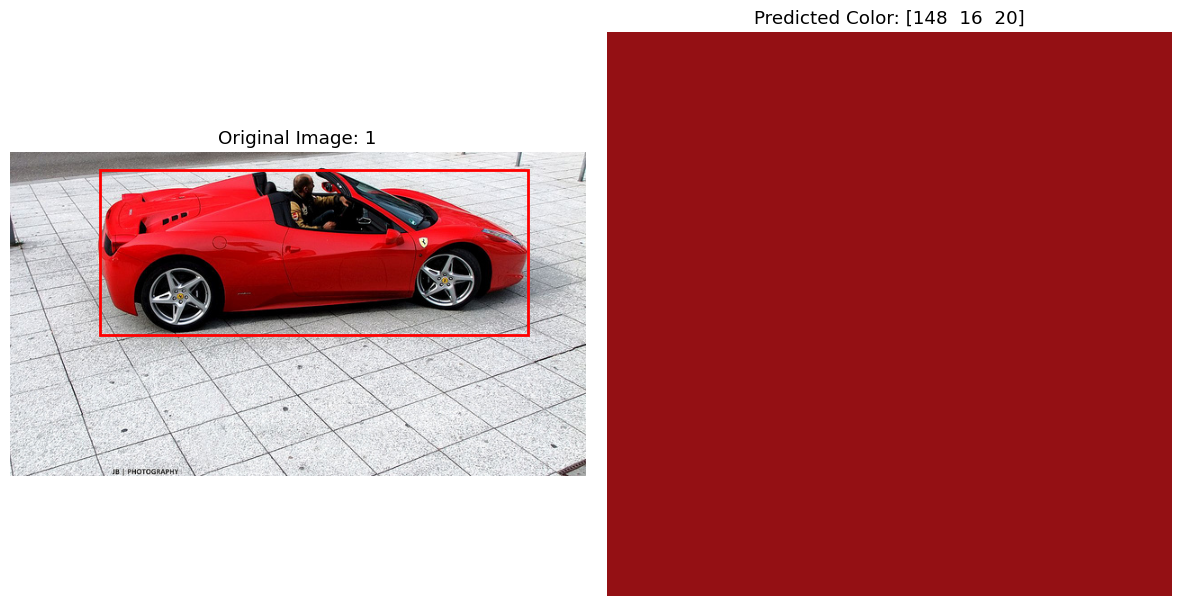

array([        148,          16,          20])

In [181]:
visualize_prediction(1, test_dataset)